In [1]:
import os
import shutil

In [2]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import researchpy as rp
import seaborn as sns
import statsmodels.api as sm
from pandas.core.frame import DataFrame
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer

In [3]:
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols

In [4]:
DETAILED_OUTPUT_MODE = False
DATA_FILEPATH = 'resources/products.csv'

In [5]:
TARGET_COLUMN = "nutrition_grade_fr"
CONSIDERED_COLUMNS = ["product_name", "nutrition_grade_fr", "energy_100g", "proteins_100g", "carbohydrates_100g",
                      "sugars_100g", "fat_100g"]

In [6]:
# Configuration
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
sns.set_theme()
pd.set_option("future.no_silent_downcasting", True)

In [7]:
def get_dtype(column_name: str) -> str:
    if column_name.endswith("_t"):
        return "timedelta64"
    elif column_name.endswith("_datetime"):
        return "datetime64"
    elif column_name.endswith("_100g"):
        return "float64"
    else:
        return "str"

In [8]:
def load_data_using_dtype_setting(nrows: int) -> DataFrame:
    columns_name = pd.read_csv(DATA_FILEPATH, sep="	", nrows=0).columns

    dtypes = {}
    converters = {}
    for column_name in columns_name:
        column_type = get_dtype(column_name)

        if column_type == "datetime64":
            converters[column_name] = lambda x: pd.to_datetime(x, errors='coerce', format='ISO8601')
        elif column_type == "timedelta64":
            converters[column_name] = lambda x: pd.to_timedelta(x, errors="coerce")
        elif column_name.endswith("_tags"):
            converters[column_name] = lambda x: str(x).split(',') if isinstance(x, str) else []
        else:
            dtypes[column_name] = column_type

    return pd.read_csv(DATA_FILEPATH, header=0, sep="	", nrows=nrows, dtype=dtypes, converters=converters)

In [9]:
def load_data_from_csv_file(nrows: int) -> DataFrame:
    # df = load_data_using_dtype_guessing(nrows)
    df = load_data_using_dtype_setting(nrows)
    print("Data successfully loaded.\n")

    return df

In [10]:
def load_data_using_dtype_guessing(nrows: int) -> DataFrame:
    df = pd.read_csv(DATA_FILEPATH, header=0, sep="	", nrows=nrows, low_memory=False)
    columns_name = pd.read_csv(DATA_FILEPATH, sep="	", nrows=0).columns

    for column_name in columns_name:
        if column_name.endswith("_t"):
            df[column_name] = pd.to_timedelta(df[column_name], unit='s', errors='coerce')
        elif column_name.endswith("_datetime"):
            df[column_name] = pd.to_datetime(df[column_name], errors='coerce', format='ISO8601')
        elif column_name.endswith("_tags"):
            df[column_name] = df[column_name].apply(
                lambda x: x[1:-1].split(',') if isinstance(x, str) else [])

    return df

In [11]:
def display_type_of_each_column(df: DataFrame) -> None:
    print(df.dtypes)
    print("\n")

In [12]:
def display_all_nan_values_of_column(df: DataFrame, column_name: str) -> None:
    for item in df[column_name]:
        if pd.notna(item):
            print(item)
    print("\n")

In [13]:
def display_information_missing_values_and_produces_plot(df: DataFrame, filename: str) -> None:
    # print(df.info())
    # print("\n")

    present_data_percentages = df.notna().mean().sort_values(ascending=False)

    print("Listing present data percentages for each column:")
    print(present_data_percentages)
    print("\n")

    print("Showing present data per column in plot:")
    plot = msno.bar(df, figsize=(5, 6))
    save_plot(plot, filename, "missing_values")

In [14]:
def save_plot(plot, filename: str, prefix: str) -> None:
    os.makedirs(f"plots/{prefix}", exist_ok=True)
    plt.show()
    # fig = plot.get_figure()
    # fig.savefig(f"plots/{prefix}/{filename}.png")
    plt.close()

In [15]:
def remove_duplicates(dataframe: DataFrame) -> None:
    initial_count = len(dataframe)
    pd.DataFrame.drop_duplicates(dataframe, subset=['product_name', 'quantity', 'brands'], inplace=True)
    duplicates_number = initial_count - len(dataframe)
    print(f"{duplicates_number} duplicates were removed based on the product name, brand and quantity columns.\n")

In [16]:
def load_and_filter_data(nrows: int = 10000000) -> DataFrame:
    df: DataFrame = load_data_from_csv_file(nrows)
    remove_duplicates(df)
    return df[CONSIDERED_COLUMNS]

In [17]:
def get_the_outliers_values(column_name: str, df: DataFrame,
                            percentage_defining_outliers: float = 0.25) -> DataFrame:
    filtered_dataframe = df[df[column_name].notna()]
    filtered_dataframe = filtered_dataframe[column_name]

    outliers_values = extract_outliers_values(filtered_dataframe, percentage_defining_outliers)
    outliers_dataframe = df[df[column_name].isin(outliers_values)].sort_values(by=column_name,
                                                                               ascending=False)
    if DETAILED_OUTPUT_MODE:
        print(f"Here are the outliers in the column:{column_name}\n")
        print(outliers_dataframe[['product_name', column_name]])
        print("\n")

    return outliers_dataframe

In [18]:
def extract_outliers_values(filtered_dataframe: DataFrame, percentage_defining_outliers: float) -> DataFrame:
    first_quantile = filtered_dataframe.quantile(percentage_defining_outliers)
    last_quantile = filtered_dataframe.quantile(1 - percentage_defining_outliers)
    interquantile_range = last_quantile - first_quantile
    mask = ((filtered_dataframe < first_quantile - 1.5 * interquantile_range) |
            (filtered_dataframe > last_quantile + 1.5 * interquantile_range))

    return filtered_dataframe[mask]

In [19]:
def input_missing_values(df: DataFrame, column_to_fill: str) -> DataFrame:
    if DETAILED_OUTPUT_MODE:
        present_values = df[df[column_to_fill].notna()]
        print(f"Count of values before imputation: {present_values[column_to_fill].count()}")
        print("\n")
        # missing_values_index = df[df[column_to_fill].isna()].index

    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor())

    new_dataframe: DataFrame = df.copy()
    new_dataframe[TARGET_COLUMN] = (new_dataframe[TARGET_COLUMN]
                                    .replace("a", 1).replace("b", 2).replace("c", 3).replace("d", 4).replace("e", 5))

    new_dataframe[column_to_fill] = iterative_imputer.fit_transform(
        new_dataframe[column_to_fill].values.reshape(-1, 1))[:, 0]
    new_dataframe[TARGET_COLUMN] = (new_dataframe[TARGET_COLUMN]
                                    .replace(1, "a").replace(2, "b").replace(3, "c").replace(4, "d").replace(5, "e"))
    if DETAILED_OUTPUT_MODE:
        present_values_after_inputation = new_dataframe[new_dataframe[column_to_fill].notna()]
        print(f"Count of values after imputation: {present_values_after_inputation[column_to_fill].count()}")
        print("\n")
        # print("Rows with imputed values:\n")
        # print(DataFrame(new_dataframe, index=missing_values_index, columns=['product_name', column_to_fill]))

    return new_dataframe

In [20]:
def remove_values_outside_ranges(df: DataFrame) -> DataFrame:
    if DETAILED_OUTPUT_MODE:
        print(f"Starting to clean the rows with values outside of the normal ranges\n")

    for column_name in df.columns:
        if DETAILED_OUTPUT_MODE:
            print(f"{column_name}: before:{len(df)}")

        if column_name == "energy_100g":
            df = df[(df[column_name] >= 0) & (df[column_name] <= 3765.6)]
        elif column_name.endswith("_100g"):
            df = df[(df[column_name] >= 0) & (df[column_name] <= 100)]
        elif column_name == "nutrition_grade_fr":
            df = df[(df[column_name].isna()) | (df[column_name].isin(['a', 'b', 'c', 'd', 'e']))]
        elif column_name == "product_name":
            df = df[df[column_name].notna()]

        if DETAILED_OUTPUT_MODE:
            print(f"{column_name}: after:{len(df)}")

    df = df[(df["proteins_100g"] + df['carbohydrates_100g'] + df['sugars_100g'] + df['fat_100g'] <= 100)]
    if DETAILED_OUTPUT_MODE:
        print(f"\nAfter cleaning the rows when the sum of the components > 100gr: {len(df)}\n\nCleaning based on the ranges of values is now done.\n")

    return df

In [21]:
def remove_outliers_values(df: DataFrame) -> DataFrame:
    if DETAILED_OUTPUT_MODE:
        print("Cleaning the outliers values\n")

    for column_name in df.columns:
        if column_name == "proteins_100g":
            outliers_dataframe = get_the_outliers_values(column_name, df, percentage_defining_outliers=0.007)
            df = df.drop(outliers_dataframe.index)
        elif column_name == "sugars_100g":
            outliers_dataframe = get_the_outliers_values(column_name, df, percentage_defining_outliers=0.011)
            df = df.drop(outliers_dataframe.index)

    if DETAILED_OUTPUT_MODE:
        print("Outliers values have been removed\n")

    return df

In [22]:
def save_univariate_analysis_plot(df: DataFrame, step: str, plot_types: list[str] = ['boxplot'],
                                  prefix: str = "univariate_analysis") -> None:
    for column_name in df.columns:
        if column_name.endswith("_100g"):
            if "boxplot" in plot_types:
                boxplot = (sns.boxplot(data=df, x=column_name, showmeans=True)
                           .set_title(f"Boxplot of {column_name} {step}".replace("_", " ")))
                save_plot(boxplot, f"{column_name}_{step}_boxplot", prefix)

            if "histogram" in plot_types:
                plt.figure(figsize=(7, 5))
                histogram = (sns.histplot(data=df, x=column_name, kde=False)
                             .set_title(f"Histogram of {column_name} {step}".replace("_", " ")))
                plt.axvline(x=df[column_name].median(), linewidth=3, color='y', label="median", alpha=0.5)
                save_plot(histogram, f"{column_name}_{step}_histogram", prefix)

    create_nutrition_grade_pieplot(df, f"{prefix}/nutrition_grade_pieplot.png")

In [23]:
def create_nutrition_grade_pieplot(df: DataFrame, filename: str) -> None:
    data = [df['nutrition_grade_fr'].value_counts()['a'],
            df['nutrition_grade_fr'].value_counts()['b'],
            df['nutrition_grade_fr'].value_counts()['c'],
            df['nutrition_grade_fr'].value_counts()['d'],
            df['nutrition_grade_fr'].value_counts()['e']]
    labels = ['a', 'b', 'c', 'd', 'e']

    colors = sns.color_palette('pastel')[0:5]
    plt.title("Pie plot of the nutrition grade")
    plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')
    # plt.savefig(f"plots/{filename}")
    plt.show()
    plt.close()

In [24]:
def clean_dataset(df: DataFrame) -> DataFrame:
    print(f"Size of the dataset before cleaning:{len(df)}")

    save_univariate_analysis_plot(df, "before_cleaning")
    df = remove_values_outside_ranges(df)

    # save_univariate_analysis_plot(df, "after_cleaning_values_outside_ranges")
    df = remove_outliers_values(df)

    # The second univariate analysis will be done after the inputation of missing values, this one is not needed in the final version
    # save_univariate_analysis_plot(df, "after_cleaning", plot_types=['boxplot', 'histogram'])
    print(f"Size of the dataset after cleaning:{len(df)}\n")

    return df

In [25]:
def remove_last_run_plots():
    shutil.rmtree('plots')
    os.mkdir('plots')

In [26]:
def perform_bivariate_analysis(df, is_after_imputation=False):
    order = ['a', 'b', 'c', 'd', 'e']
    plot_prefix_path = "bivariate_analysis" if not is_after_imputation else "bivariate_analysis_after_imputation"

    for column_name in df.columns:
        if column_name.endswith("_100g"):
            boxplot = (sns.boxplot(data=df, x=df[TARGET_COLUMN], y=column_name, order=order, showmeans=True)
                       .set_title(f"Bivariate analysis of {column_name}"))
            save_plot(boxplot, f"{column_name}_boxplot", plot_prefix_path)

            stripplot = sns.stripplot(data=df, x=TARGET_COLUMN, y=column_name, order=['a', 'b', 'c', 'd', 'e'])
            save_plot(stripplot, f"{column_name}_stripplot", plot_prefix_path)

            violin_plot = sns.violinplot(data=df, x=df[TARGET_COLUMN], y=column_name, order=order)
            save_plot(violin_plot, f"{column_name}_violinplot", plot_prefix_path)

    create_heatmap(df, plot_prefix_path)

In [27]:
def create_heatmap(df: DataFrame, plot_prefix_path: str):
    quantitative_df = (df.drop(columns=["product_name"])
                       .replace("a", 1).replace("b", 2).replace("c", 3).replace("d", 4).replace("e", 5))
    matrix = quantitative_df.corr().round(2)

    plt.subplots(figsize=(13, 11))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # To only display the lower half of the matrix
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    heatmap = sns.heatmap(matrix, cmap=cmap, mask=mask, square=True, linewidths=.5, cbar_kws={"shrink": .5})

    # heatmap = sns.heatmap(matrix, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    save_plot(heatmap, f"heatmap", plot_prefix_path)

In [28]:
def perform_acp_analysis(df, is_after_imputation):
    print("ACP analysis")
    quantitative_df = (df.drop(columns=["product_name"])
                       .replace("a", 1).replace("b", 2).replace("c", 3).replace("d", 4).replace("e", 5)).dropna()
    plots_prefix_path = "acp" if not is_after_imputation else "acp_after_imputation"

    n_components = 6
    os.makedirs(f"plots/{plots_prefix_path}")
    features = quantitative_df.columns

    pca = PCA(n_components=n_components)
    scaled_X = StandardScaler().fit_transform(quantitative_df)
    pca.fit_transform(scaled_X)
    x_list = range(1, n_components + 1)

    create_inertia_plot(pca, x_list, plots_prefix_path)

    if DETAILED_OUTPUT_MODE:
        print("The components of the PCA are:")
        pcs = pd.DataFrame(pca.components_)
        pcs.columns = features
        pcs.index = [f"F{i}" for i in x_list]
        pcs.round(2)
        print(pcs)
        print("\n")

    create_correlation_circle_plot(features, (0, 1), pca, plots_prefix_path)
    create_correlation_circle_plot(features, (2, 3), pca, plots_prefix_path)

In [29]:
def create_correlation_circle_plot(features, x_y, pca, plots_prefix_path):
    x, y = x_y
    fig, ax = plt.subplots(figsize=(10, 9))

    for i in range(0, pca.components_.shape[1]):
        ax.arrow(0, 0,
                 pca.components_[x, i],
                 pca.components_[y, i],
                 head_width=0.07,
                 head_length=0.07,
                 width=0.02, )

        plt.text(pca.components_[x, i] + 0.05,
                 pca.components_[y, i] + 0.05,
                 features[i])

    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    plt.xlabel('F{} ({}%)'.format(x + 1, round(100 * pca.explained_variance_ratio_[x], 1)))
    plt.ylabel('F{} ({}%)'.format(y + 1, round(100 * pca.explained_variance_ratio_[y], 1)))
    plt.title("Cercle des corrélations (F{} et F{})".format(x + 1, y + 1))

    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
    plt.axis('equal')
    plt.show()
    # plt.savefig(f"plots/{plots_prefix_path}/Correlations_circle_F{x + 1}_F{y + 1}.png")
    plt.close()

In [30]:
def create_inertia_plot(pca, x_list, plots_prefix_path):
    inertia_percentages = (pca.explained_variance_ratio_ * 100).round(2)
    cumulative_inertia_percentages = inertia_percentages.cumsum().round()

    plt.bar(x_list, inertia_percentages)
    plt.plot(x_list, cumulative_inertia_percentages, c="red", marker='o')

    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    
    plt.show()
    # plt.savefig(f"plots/{plots_prefix_path}/eboulis_des_valeurs_propres.png")
    plt.close()

In [31]:
def perform_anova_analysis(df):
    print("Anova analysis")
    for column in df.columns:
        if column.endswith("_100g"):
            print(f"\n\nanalysis of column:{column}")

            if DETAILED_OUTPUT_MODE:
                result = rp.summary_cont(df[column].groupby(df[TARGET_COLUMN]))
                print(result)
                print("\n")

            model = ols(f'{column} ~ C({TARGET_COLUMN})', data=df).fit()
            if DETAILED_OUTPUT_MODE:
                print(model.summary())
                print("\n")

            aov_table = sm.stats.anova_lm(model, typ=2)
            print(aov_table)

In [32]:
def perform_multivaried_analysis(df: DataFrame, is_after_imputation=False) -> None:
    perform_acp_analysis(df, is_after_imputation)
    perform_anova_analysis(df)

The script has started.

Data successfully loaded.

32703 duplicates were removed based on the product name, brand and quantity columns.

The dataset has been loaded and filtered. Let's clean the data.

Listing present data percentages for each column:
product_name          0.994567
energy_100g           0.841850
proteins_100g         0.837955
sugars_100g           0.790988
fat_100g              0.782715
carbohydrates_100g    0.781636
nutrition_grade_fr    0.717401
dtype: float64


Showing present data per column in plot:


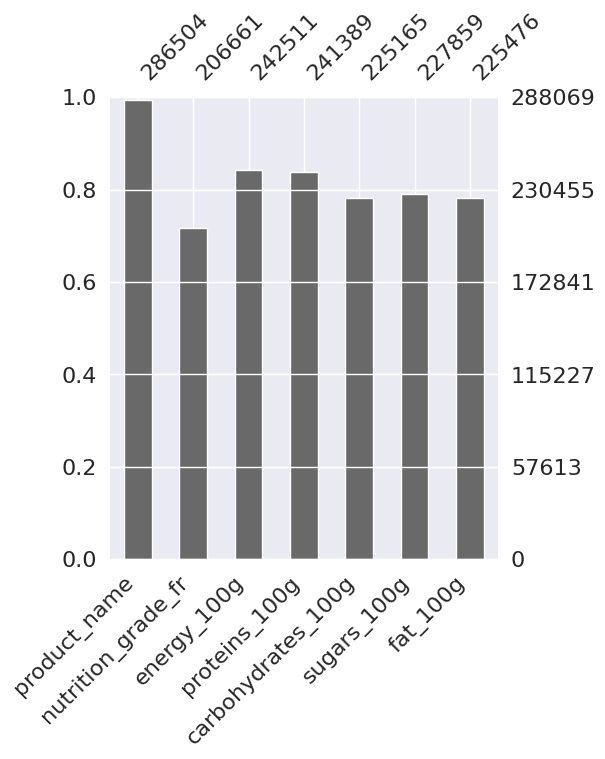

Size of the dataset before cleaning:288069


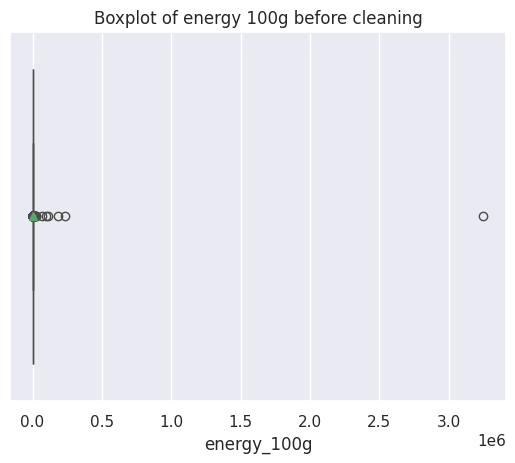

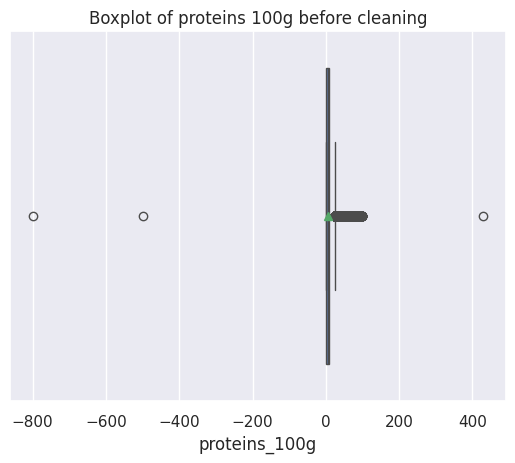

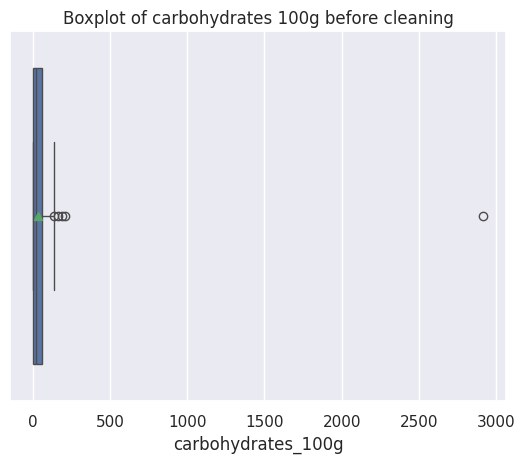

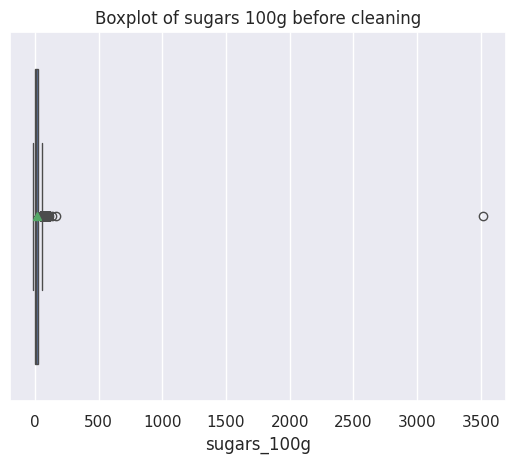

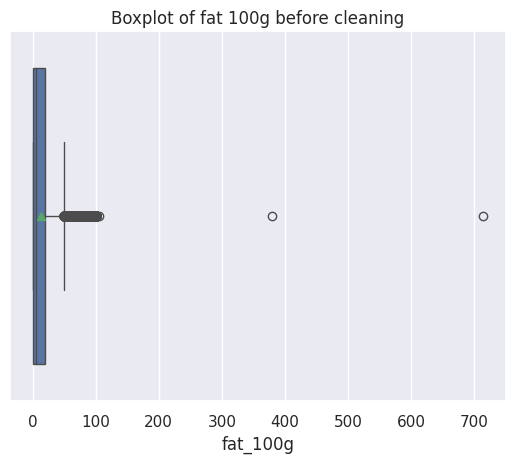

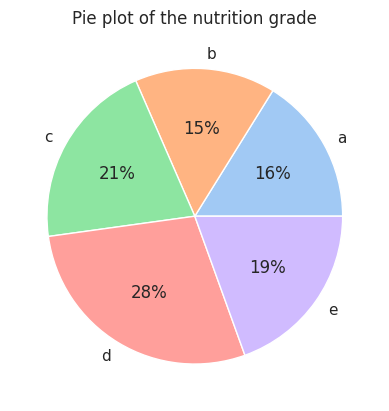

Size of the dataset after cleaning:154711

Listing present data percentages for each column:
product_name          1.000000
energy_100g           1.000000
proteins_100g         1.000000
carbohydrates_100g    1.000000
sugars_100g           1.000000
fat_100g              1.000000
nutrition_grade_fr    0.905676
dtype: float64


Showing present data per column in plot:


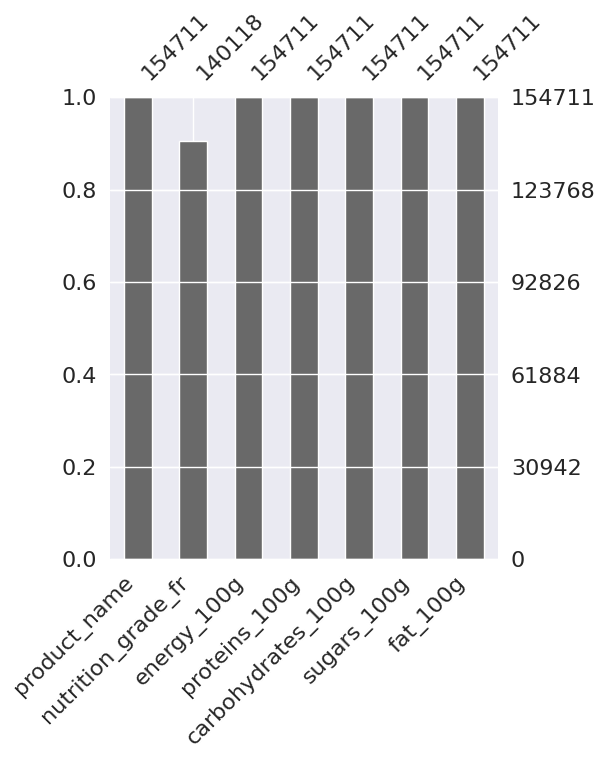

The dataset has been cleaned, let's input the missing values

The missing values have now been added

Listing present data percentages for each column:
product_name          1.0
nutrition_grade_fr    1.0
energy_100g           1.0
proteins_100g         1.0
carbohydrates_100g    1.0
sugars_100g           1.0
fat_100g              1.0
dtype: float64


Showing present data per column in plot:


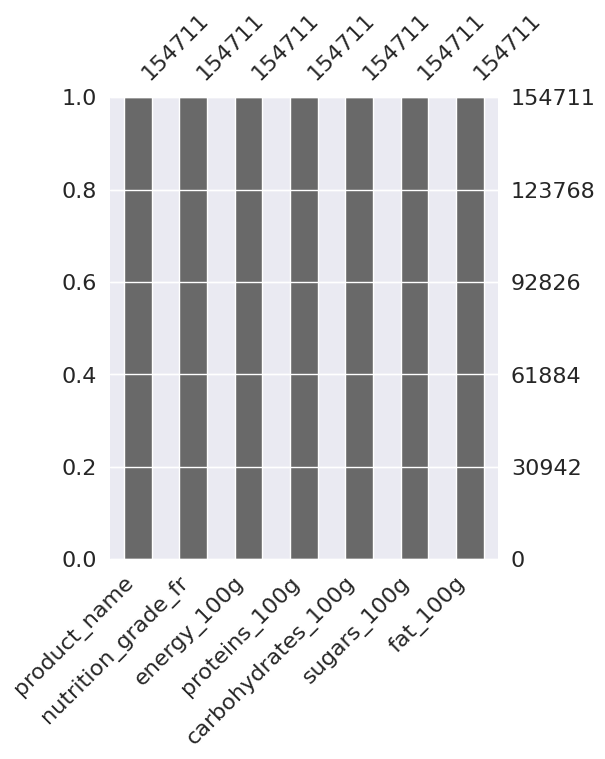

Performing now new univariate analysis



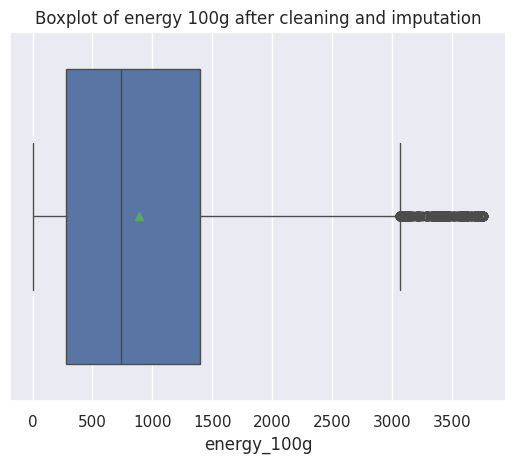

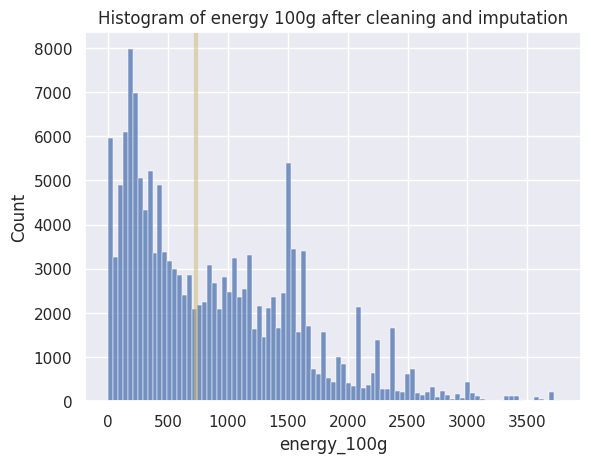

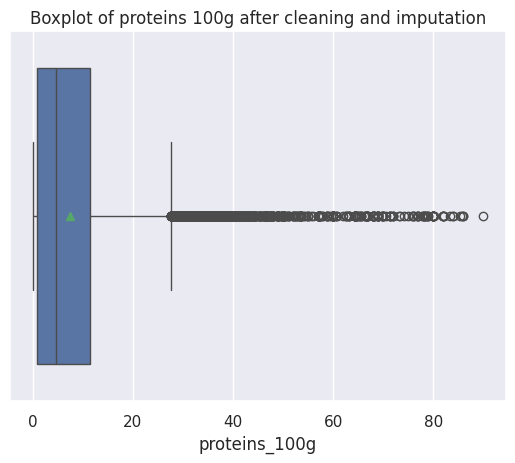

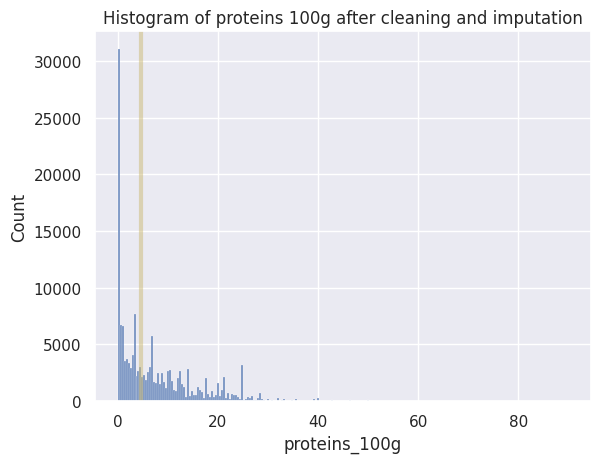

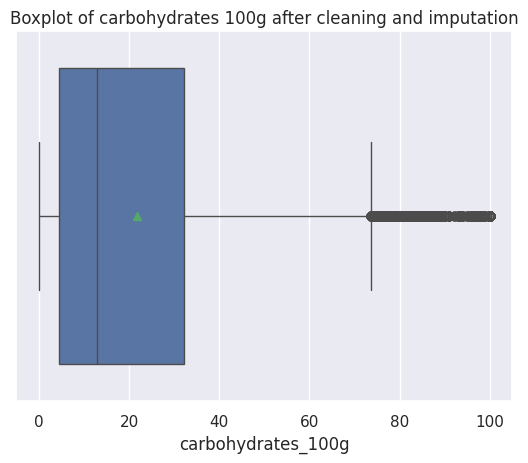

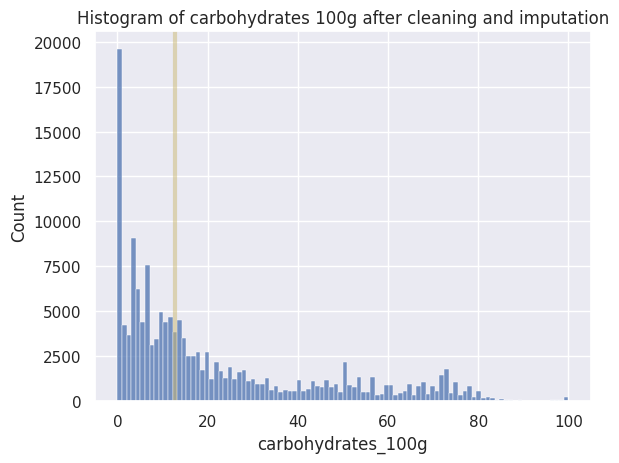

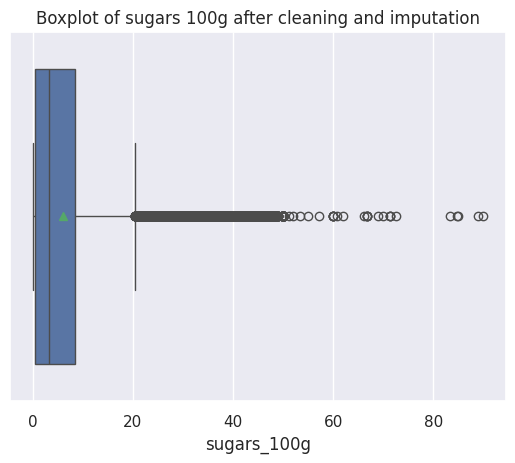

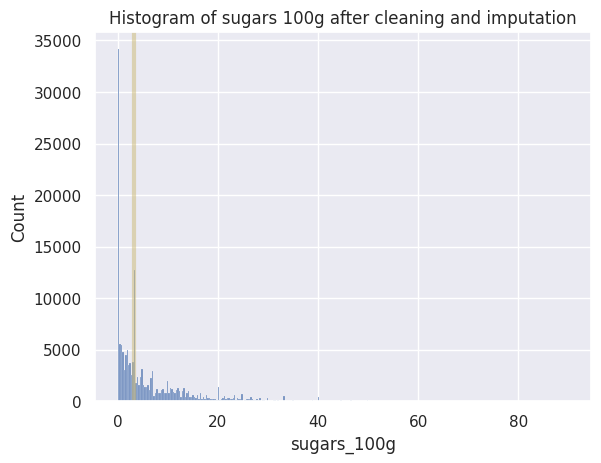

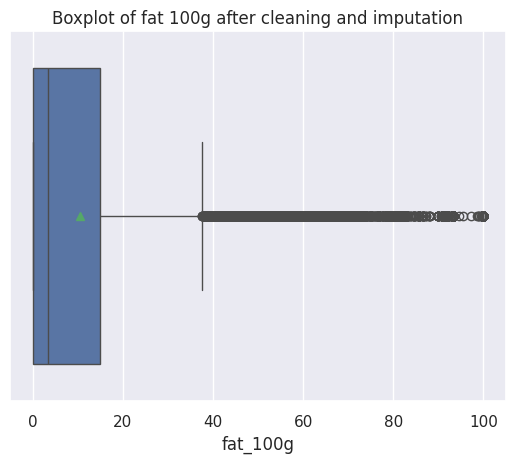

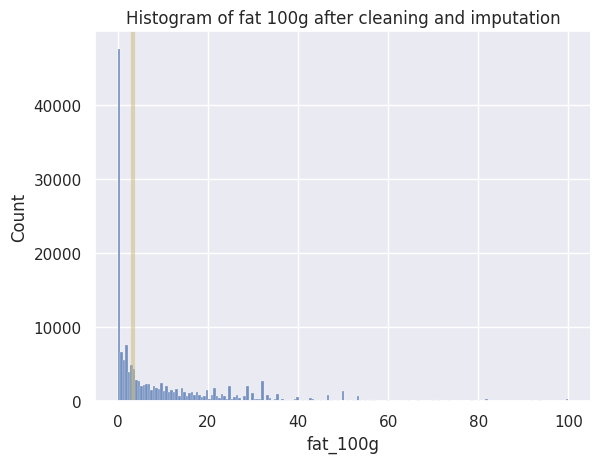

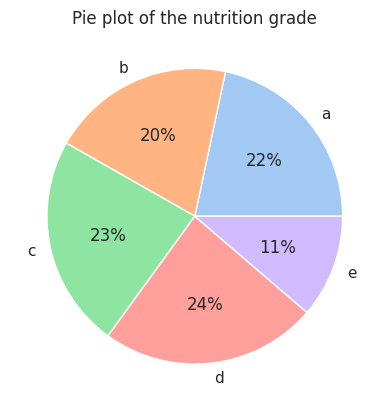

Performing now bivariate analysis



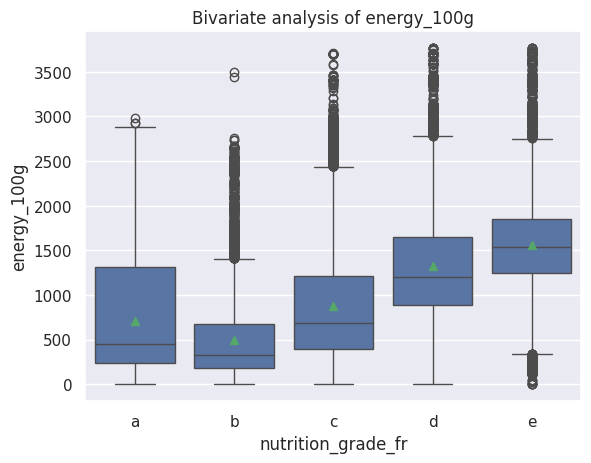

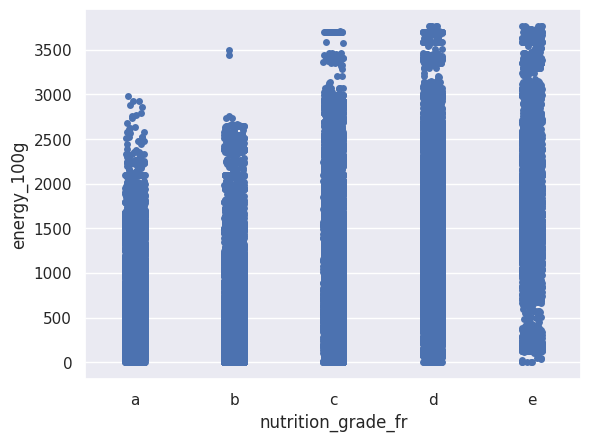

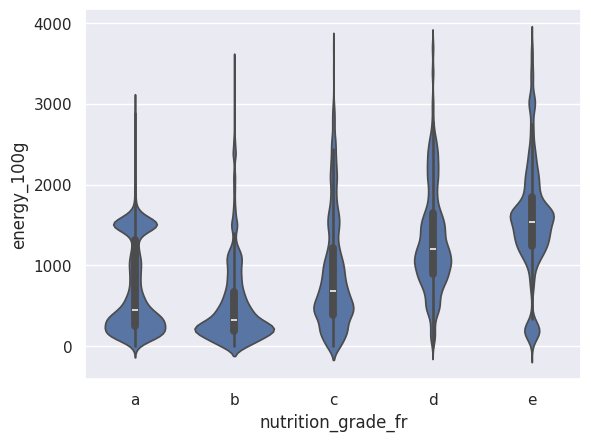

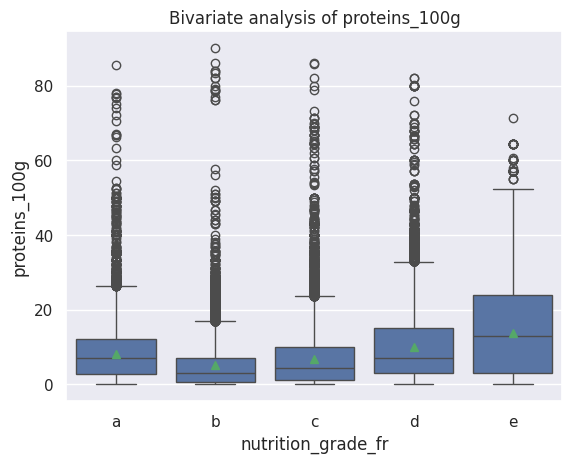

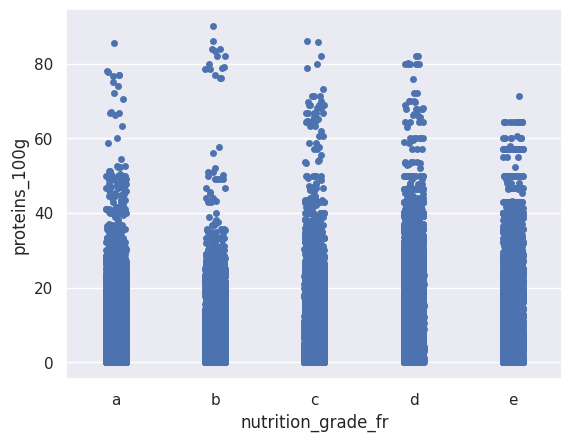

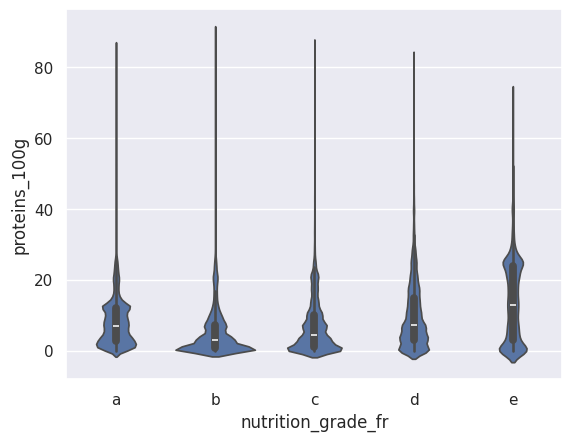

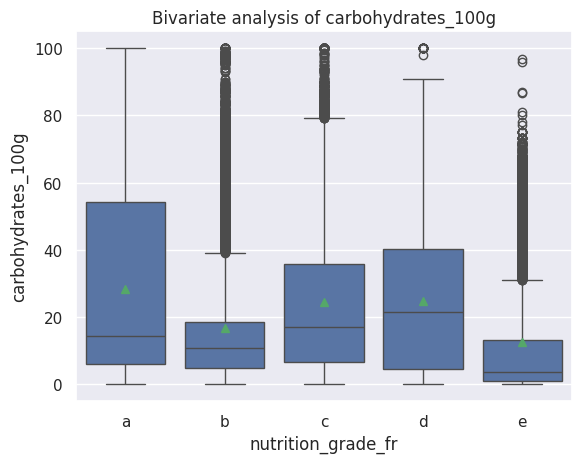

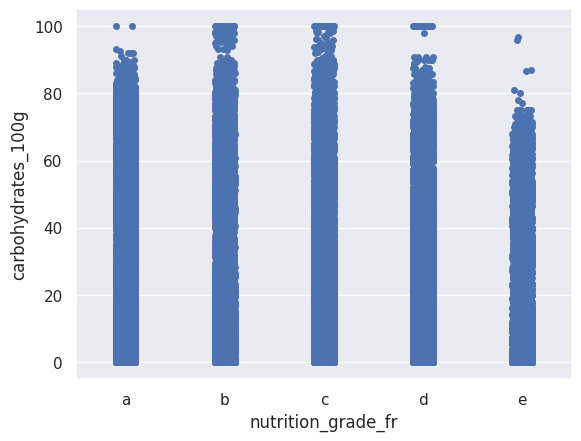

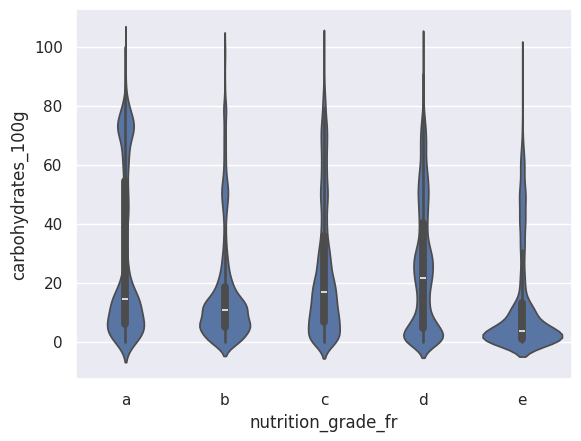

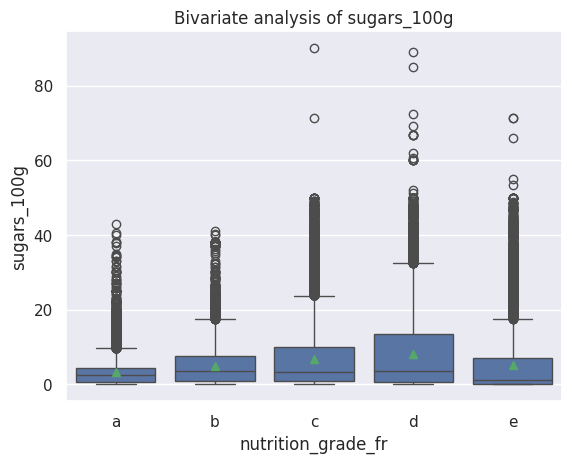

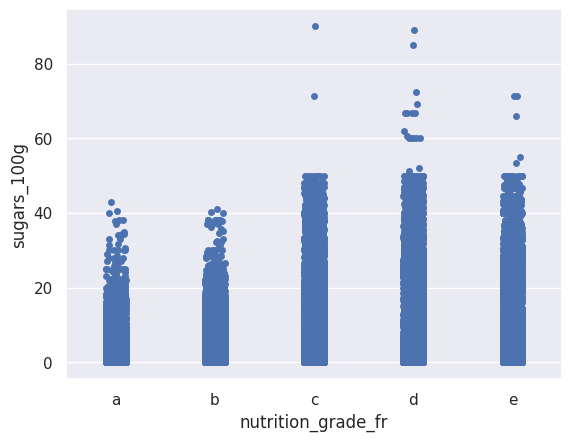

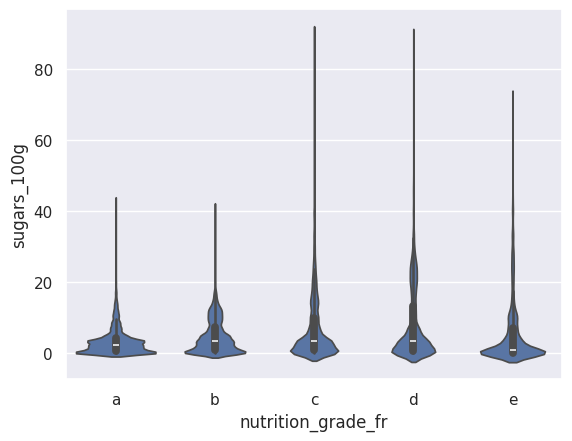

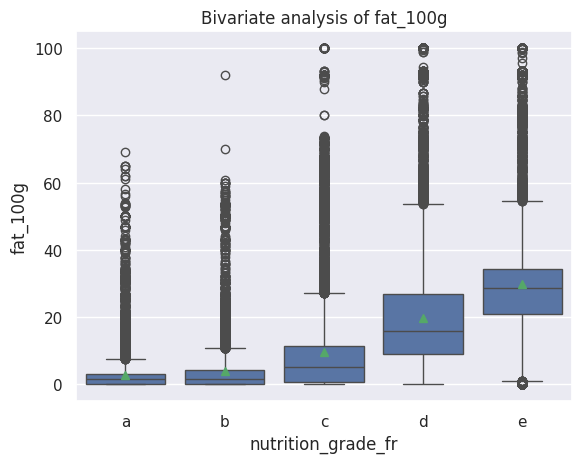

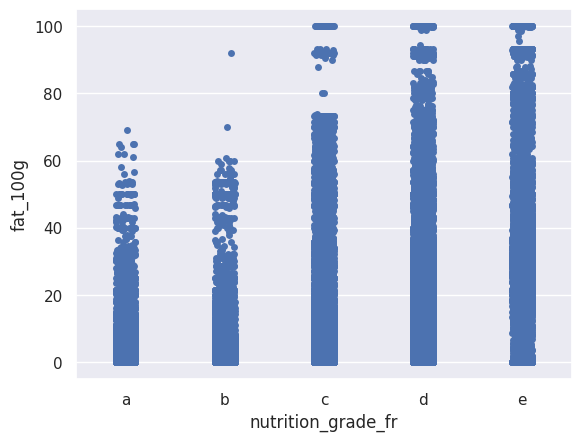

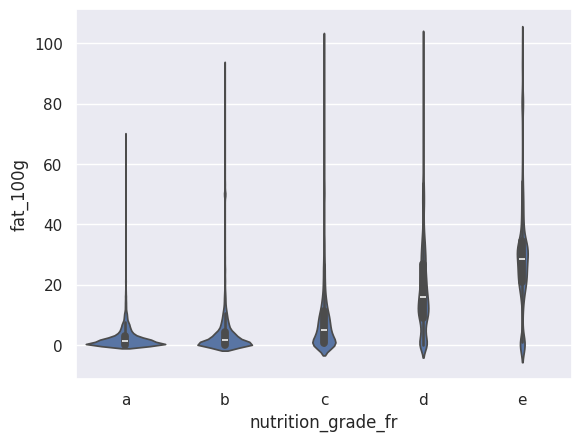

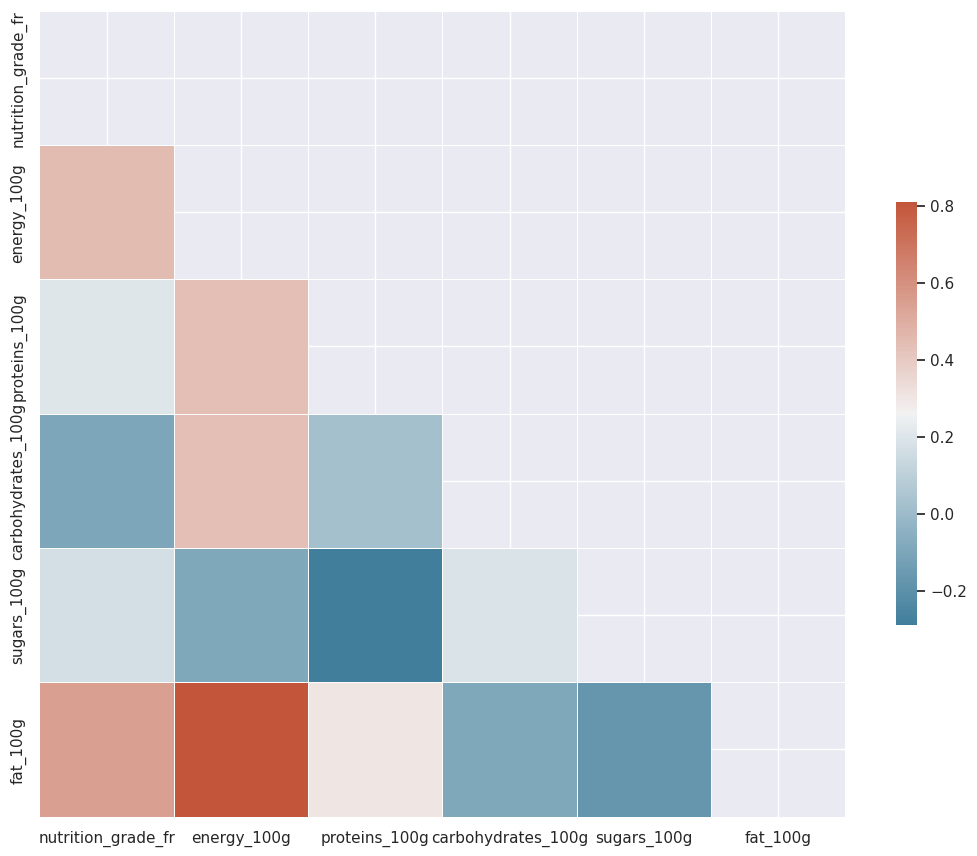

Performing now multivaried analysis

ACP analysis


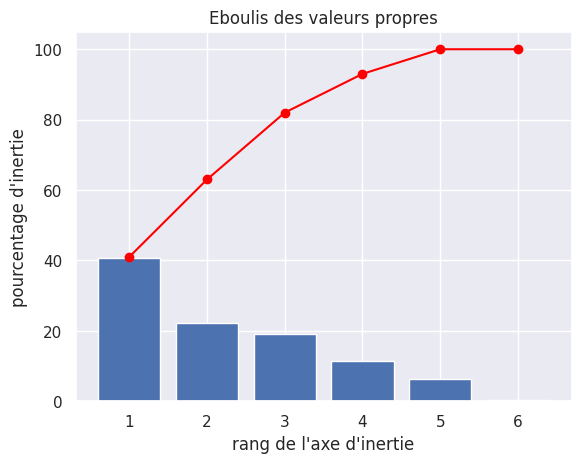

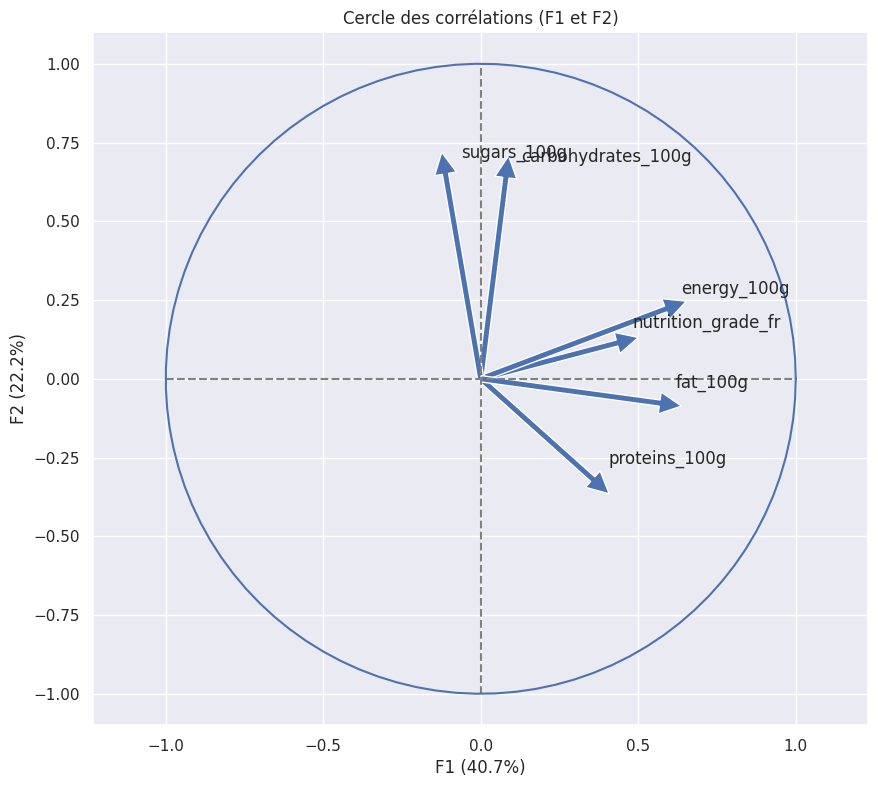

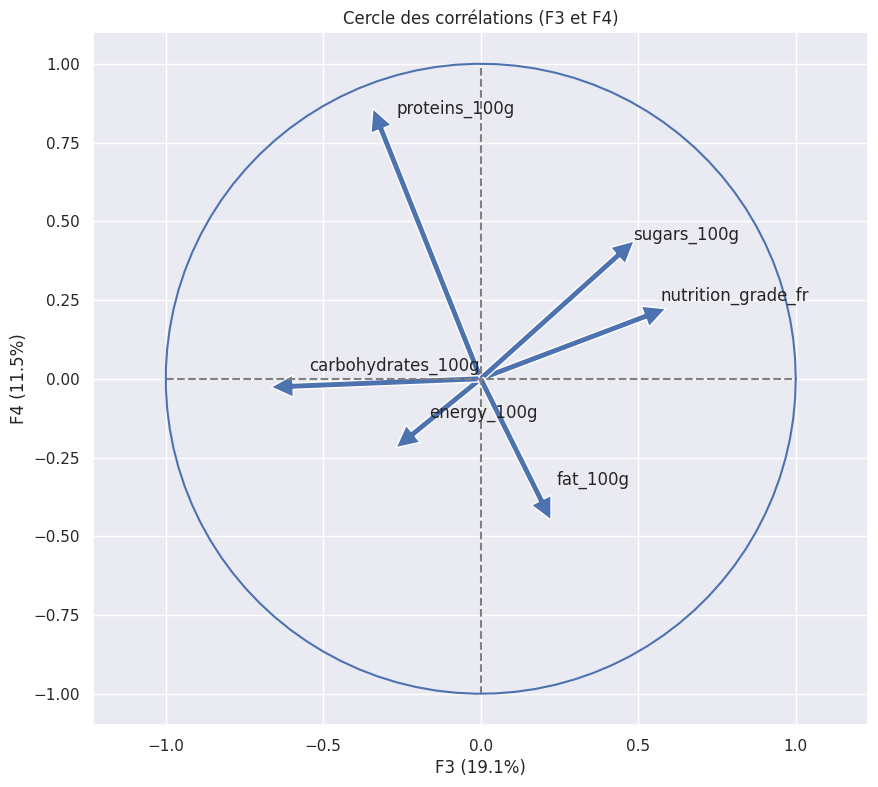

Anova analysis


analysis of column:energy_100g
                             sum_sq        df             F  PR(>F)
C(nutrition_grade_fr)  1.816085e+10       4.0  12117.769303     0.0
Residual               5.249669e+10  140113.0           NaN     NaN


analysis of column:proteins_100g
                             sum_sq        df            F  PR(>F)
C(nutrition_grade_fr)  8.981896e+05       4.0  3440.857927     0.0
Residual               9.143652e+06  140113.0          NaN     NaN


analysis of column:carbohydrates_100g
                             sum_sq        df            F  PR(>F)
C(nutrition_grade_fr)  3.864510e+06       4.0  1923.692834     0.0
Residual               7.036832e+07  140113.0          NaN     NaN


analysis of column:sugars_100g
                             sum_sq        df            F  PR(>F)
C(nutrition_grade_fr)  4.221265e+05       4.0  1891.660422     0.0
Residual               7.816600e+06  140113.0          NaN     NaN


analysis of column:fat_100g
       

In [33]:
if __name__ == '__main__':
    print("The script has started.\n")
    remove_last_run_plots()

    dataframe: DataFrame = load_and_filter_data()
    print("The dataset has been loaded and filtered. Let's clean the data.\n")

    display_information_missing_values_and_produces_plot(dataframe, "missing_values_before_cleaning")
    cleaned_dataframe = clean_dataset(dataframe)
    display_information_missing_values_and_produces_plot(cleaned_dataframe, "missing_values_after_cleaning")

    # First analysis performed before the input of the missing data, not needed in the final version 
    # print("The dataset has been cleaned, starting bivariate and multivaried analysis\n")

    # perform_bivariate_analysis(cleaned_dataframe)
    # perform_multivaried_analysis(cleaned_dataframe)

    # print("\nAnalysis done, let's input the missing values\n")

    print("The dataset has been cleaned, let's input the missing values\n")

    filled_dataframe: DataFrame = input_missing_values(cleaned_dataframe, TARGET_COLUMN)
    print("The missing values have now been added\n")

    display_information_missing_values_and_produces_plot(filled_dataframe, "missing_values_after_imputation")
    
    print("Performing now new univariate analysis\n")
    save_univariate_analysis_plot(filled_dataframe, "after_cleaning_and_imputation", plot_types=['boxplot', 'histogram'], prefix="univariate_analysis_after_imputation")

    print("Performing now bivariate analysis\n")
    perform_bivariate_analysis(cleaned_dataframe, is_after_imputation=True)

    print("Performing now multivaried analysis\n")
    perform_multivaried_analysis(cleaned_dataframe, is_after_imputation=True)

    print("\n\nAll done, have a nice day!")